# Experiments

The ff. experiments demonstrate bias-variance tradeoff for neural networks:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x = torch.linspace(-10, 10, 1000)
y = 3 * torch.sin(x) + torch.cos(torch.pi * x)


def model(width, sample_size, alpha=0.0, x=x, y=y):
    """Fitting a wide fully connected ReLU network."""
    
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    N = torch.randint(0, 1000, size=(sample_size,))
    N = torch.sort(N)[0]
    xs = x[N]
    ys = y[N]

    net = nn.Sequential(
        nn.Linear(1, width),
        nn.Tanh(),
        nn.Linear(width, 1)
    )
    theta = net.parameters()
    optim = torch.optim.Adam(theta, lr=0.1, weight_decay=alpha)

    # 100 steps on the fixed sample
    for _ in range(100):
        loss = F.mse_loss(ys, net(xs))
        loss.backward()
        optim.step()
        optim.zero_grad()

    return net(x).reshape(-1)

Recall that we analyze variations of trained models w.r.t. samples of (1) training data $\mathcal{D}$ and (2) test inputs $\boldsymbol{\mathsf{x}} \sim P$. 
The `num_models` parameter in the `run` function below is the number of models that we train.
Let $m$ be the size of the test set.
The `run` function returns a stack of test predictions $\hat{\boldsymbol{\mathsf{Y}}} \in \mathbb{R}^{m \times n_\text{models}}$ for every training where $\hat{\boldsymbol{\mathsf{Y}}}_{ij} = f_{\mathcal{D}_j}(\boldsymbol{\mathsf{x}}_i).$ It follows that the bias and variance can be calculated as follows:

$$
\begin{aligned}
\mathbb{E}_{\boldsymbol{\mathsf{x}}}\left[(\bar{f}(\boldsymbol{\mathsf{x}})-f(\boldsymbol{\mathsf{x}}))^2\right] &\approx \frac{1}{m}\sum_{i} \left( \left(\frac{1}{n_\text{models}}\sum_{j} \hat{\boldsymbol{\mathsf{Y}}}_{ij}\right) - \boldsymbol{\mathsf{y}}_i \right)^2
\\
\mathbb{E}_{\boldsymbol{\mathsf{x}}, \mathcal{D}}\left[\left(f_{\mathcal{D}}(\boldsymbol{\mathsf{x}})-\bar{f}(\boldsymbol{\mathsf{x}})\right)^2\right] &\approx \frac{1}{m \cdot n_\text{models}}\sum_{i} \sum_j \left( \hat{\boldsymbol{\mathsf{Y}}}_{ij} - \left(\frac{1}{n_\text{models}}\sum_{j^\prime} \hat{\boldsymbol{\mathsf{Y}}}_{i{j^\prime}}\right)  \right)^2
\end{aligned}
$$

Note that bias computation depends on the ground truth, while variance only considers predictions. 

In [2]:
def run(num_models=300, width=6, sample_size=6, alpha=0.0):
    y_preds = []
    for _ in range(num_models):
        y_pred = model(width, sample_size, alpha)
        y_preds.append(y_pred)
    return torch.stack(y_preds, dim=1)  # (1000, num_models)

def model_variance(y_preds):
    """Error between ensemble & preds over inputs and samples."""
    # (1000, num_models) -> (1000,) -> (1000, 1)
    y_pred_bar = y_preds.mean(dim=1)[:, None]
    return (y_preds - y_pred_bar).square().mean().item()

def model_bias(y_preds, y_true):
    """Error between ensemble & ground truth over inputs."""
    # (1000, num_models) -> (1000,)
    y_pred_bar = y_preds.mean(dim=1)
    return (y_true - y_pred_bar).square().mean().item()

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt


def reset_seed():
    np.random.seed(0)
    torch.manual_seed(0)

def plot_model(ax, width=6, sample_size=6, alpha=0.0, count=100):
    reset_seed()
    y_preds = run(num_models=count, width=width, sample_size=sample_size, alpha=alpha)
    for i in range(100):
        p = y_preds[:, i].detach().cpu().numpy()
        ax.plot(x, p, alpha=0.5, color="C0")
    
    v = model_variance(y_preds)
    b = model_bias(y_preds, y_true=y)
    title = f"var={v:.2f}, bias={b:.2f}, width={width}, n={sample_size}"
    if alpha > 0:
        title += f"\nα={alpha:.0e}"
    
    ax.set_title(title)
    ax.plot(x, y, color="black", linewidth=2)
    ax.set_ylim(-8, 8)

<br>

1. **Decreasing model complexity decreases variance and increases bias:**

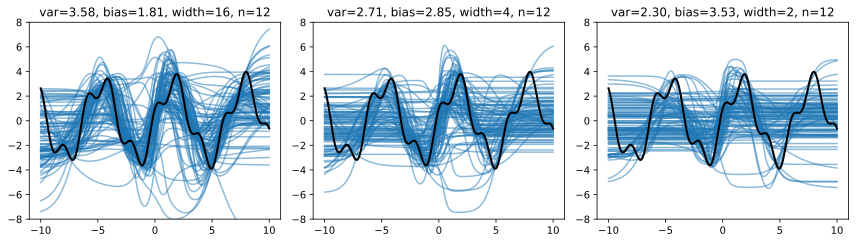

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=16, sample_size=12)
plot_model(ax[1], width=4,  sample_size=12)
plot_model(ax[2], width=2,  sample_size=12)
fig.tight_layout()

Here it is assumed that model complexity is parametrized by network width.

2. **More data decreases variance so that bias dominates:**

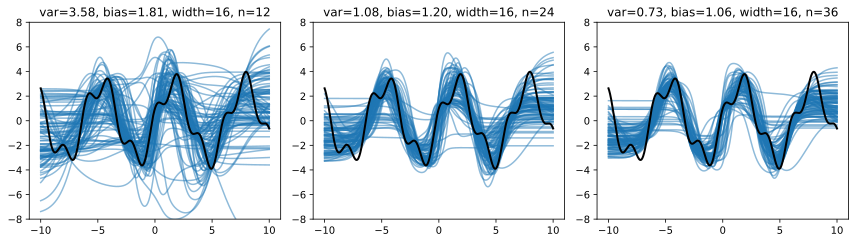

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=16, sample_size=12)
plot_model(ax[1], width=16, sample_size=24)
plot_model(ax[2], width=16, sample_size=36)
fig.tight_layout()

This makes sense: more data reduces variability in the trained models since each data point acts as an additional constraint, assuming model complexity is fixed. Performance scaling with data is less effective for models with low complexity.

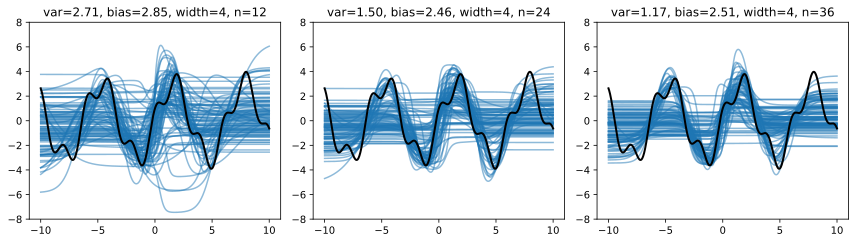

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=4, sample_size=12)
plot_model(ax[1], width=4, sample_size=24)
plot_model(ax[2], width=4, sample_size=36)
fig.tight_layout()

3. **Regularization decreases complexity:**

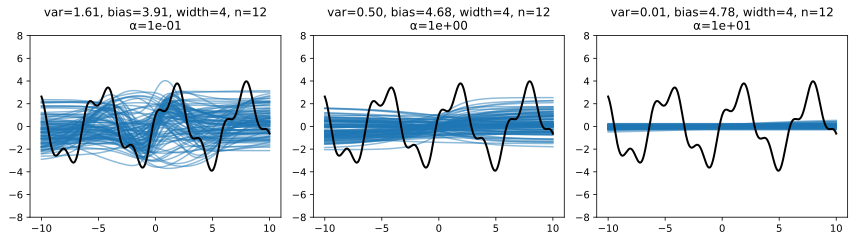

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=4, sample_size=12, alpha=0.1)
plot_model(ax[1], width=4, sample_size=12, alpha=1.0)
plot_model(ax[2], width=4, sample_size=12, alpha=10.0)
fig.tight_layout()

In practice, regularization is used to tune the bias-variance tradeoff of complex models:

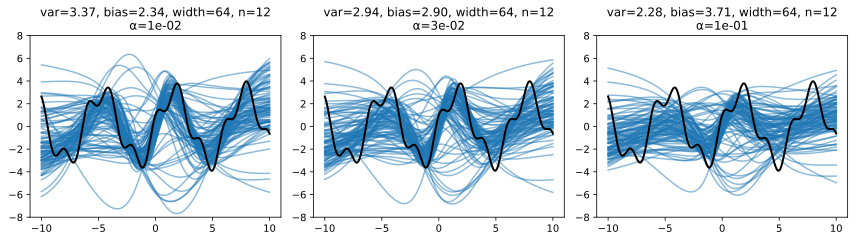

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=64, sample_size=12, alpha=0.01)
plot_model(ax[1], width=64, sample_size=12, alpha=0.03)
plot_model(ax[2], width=64, sample_size=12, alpha=0.10)
fig.tight_layout()

■